# Amazon Product Review Sentiment Analysis

### Loading Libraries

In [1]:
import bz2
import langdetect
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import numpy
import pandas
import re
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.model_selection import StratifiedKFold
import xgboost

### Loading Data

In [2]:
path = '/Users/aaronjones/Documents/data_science_projects/amazon_sentiment_analysis/'

train_file = bz2.BZ2File(path + 'train.ft.txt.bz2')
test_file = bz2.BZ2File(path + 'test.ft.txt.bz2')

train_lines = train_file.readlines()
test_lines = test_file.readlines()

train_lines = [x.decode('utf-8') for x in train_lines]
test_lines = [x.decode('utf-8') for x in test_lines]

In [3]:
# limit number of lines for development

tr_len = int(len(train_lines) * 0.05)
te_len = int(len(test_lines) * 0.05)

train_lines = train_lines[0:tr_len]
test_lines = test_lines[0:te_len]

In [4]:
lines_dict = {
    'train': train_lines,
    'test': test_lines
}

data_dict = {}
for key_ in list(lines_dict.keys()):
    temp_data = lines_dict[key_]
    temp_split = [x.split(' ', 1) for x in temp_data]
    
    # __label__1 = 0, __label__2 = 1
    label_name = key_ + '_label'
    label_value = [0 if x[0] == "__label__1" else 1 for x in temp_split]
    data_dict.update({label_name: label_value})
    
    sentence_name = key_ + '_sentence'
    sentence_value = [x[1] for x in temp_split]
    data_dict.update({sentence_name: sentence_value})

In [5]:
train_df = pandas.DataFrame({
    'LABEL': data_dict['train_label'], 
    'SENTENCE': data_dict['train_sentence'],
    'WHICH': 'Train'
})

print("Train Set: {} Rows".format(train_df.shape[0]))

Train Set: 180000 Rows


In [6]:
train_df.head(5)

,LABEL,SENTENCE,WHICH
0,1,Stuning even for the non-gamer: This sound tra...,Train
1,1,The best soundtrack ever to anything.: I'm rea...,Train
2,1,Amazing!: This soundtrack is my favorite music...,Train
3,1,Excellent Soundtrack: I truly like this soundt...,Train
4,1,"Remember, Pull Your Jaw Off The Floor After He...",Train


In [7]:
test_df = pandas.DataFrame({
    'LABEL': data_dict['test_label'], 
    'SENTENCE': data_dict['test_sentence'],
    'WHICH': 'Test'
})

print("Test Set: {} Rows".format(test_df.shape[0]))

Test Set: 20000 Rows


In [8]:
test_df.head(5)

,LABEL,SENTENCE,WHICH
0,1,Great CD: My lovely Pat has one of the GREAT v...,Test
1,1,One of the best game music soundtracks - for a...,Test
2,0,Batteries died within a year ...: I bought thi...,Test
3,1,"works fine, but Maha Energy is better: Check o...",Test
4,1,Great for the non-audiophile: Reviewed quite a...,Test


In [9]:
df_raw = train_df.append(test_df)
df_raw.reset_index(inplace=True)
df_raw.drop('index', axis=1, inplace=True)

In [10]:
del (
    train_file, test_file, train_lines, test_lines,
    lines_dict, data_dict, train_df, test_df
)

### Data Cleaning and Feature Engineering

In [11]:
# make everything lower case
df_raw['SENTENCE_EDITED'] = df_raw['SENTENCE'].apply(
    lambda w: " ".join(i.lower() for i in w.split())
)

In [12]:
# remove non-alphanumeric characters
df_raw['SENTENCE_EDITED'] = (
    df_raw['SENTENCE_EDITED'].str.replace("[^\w\s]", "")
)

###### Check for and Remove Non-English Sentences

In [13]:
def identify_language(vec):
    try:
        lang = langdetect.detect(vec)
    except:
        lang = numpy.nan
    return lang

df_raw['DETECTED_LANGUAGE'] = list(map(
    identify_language, df_raw.SENTENCE_EDITED.tolist()
))

In [14]:
print(df_raw.DETECTED_LANGUAGE.value_counts())

en    199552
es       333
fr        36
pt        15
af        13
it        11
de         9
nl         7
so         5
cy         4
hr         3
hu         3
tl         2
no         2
pl         1
sl         1
fi         1
id         1
sq         1
Name: DETECTED_LANGUAGE, dtype: int64


In [15]:
df = df_raw[df_raw['DETECTED_LANGUAGE'] == 'en'].copy()

print("Language Filter Data: {} Rows".format(df.shape[0]))

Language Filter Data: 199552 Rows


###### Lemmatization

In [16]:
lmtzr = WordNetLemmatizer()

df['SENTENCE_EDITED'] = df['SENTENCE_EDITED'].apply(
    lambda x: " ".join([lmtzr.lemmatize(i) for i in x.split()])
)

In [17]:
df.head(5)

,LABEL,SENTENCE,WHICH,SENTENCE_EDITED,DETECTED_LANGUAGE
0,1,Stuning even for the non-gamer: This sound tra...,Train,stuning even for the nongamer this sound track...,en
1,1,The best soundtrack ever to anything.: I'm rea...,Train,the best soundtrack ever to anything im readin...,en
2,1,Amazing!: This soundtrack is my favorite music...,Train,amazing this soundtrack is my favorite music o...,en
3,1,Excellent Soundtrack: I truly like this soundt...,Train,excellent soundtrack i truly like this soundtr...,en
4,1,"Remember, Pull Your Jaw Off The Floor After He...",Train,remember pull your jaw off the floor after hea...,en


###### Positive and Negative Words

In [18]:
pos_words = [
    'great', 'good', 'excellent', 'fantastic', 
    'spectacular', 'best', 'amazing', 'extraordinary',
    'impressive', 'remarkable', 'incredible', 'outstanding',
    'perfect', 'perfectly', 'pleased', 'solid',
    'powerful'
]

neg_words = [
    'bad', 'garbage', 'poor', 'worst', 'awful', 
    'unacceptable', 'cheap', 'lousy', 'disappointed', 
    'inferior', 'inadequate', 'beware', 'poor',
    'poorly', 'suck', 'crap', 'returned', 'stopped',
    'skip', 'junk', 'useless', 'refund', 'weak', 'broke',
    'annoying'
]

combined_words = pos_words + neg_words
combined_words

['great',
 'good',
 'excellent',
 'fantastic',
 'spectacular',
 'best',
 'amazing',
 'extraordinary',
 'impressive',
 'remarkable',
 'incredible',
 'outstanding',
 'perfect',
 'perfectly',
 'pleased',
 'solid',
 'powerful',
 'bad',
 'garbage',
 'poor',
 'worst',
 'awful',
 'unacceptable',
 'cheap',
 'lousy',
 'disappointed',
 'inferior',
 'inadequate',
 'beware',
 'poor',
 'poorly',
 'suck',
 'crap',
 'returned',
 'stopped',
 'skip',
 'junk',
 'useless',
 'refund',
 'weak',
 'broke',
 'annoying']

In [19]:
df['POSITIVE_KEY_WORDS'] = df['SENTENCE_EDITED'].apply(
    lambda x: "_".join(i for i in x.split() if i in pos_words)
)
df['NUM_POSITIVE_KEY_WORDS'] = df['POSITIVE_KEY_WORDS'].apply(
    lambda x: len([i for i in str(x).split("_") if i != ''])
)

df['NEGATIVE_KEY_WORDS'] = df['SENTENCE_EDITED'].apply(
    lambda x: "_".join(i for i in x.split() if i in neg_words)
)
df['NUM_NEGATIVE_KEY_WORDS'] = df['NEGATIVE_KEY_WORDS'].apply(
    lambda x: len([i for i in str(x).split("_") if i != ''])
)

In [20]:
df.head(5)

,LABEL,SENTENCE,WHICH,SENTENCE_EDITED,DETECTED_LANGUAGE,POSITIVE_KEY_WORDS,NUM_POSITIVE_KEY_WORDS,NEGATIVE_KEY_WORDS,NUM_NEGATIVE_KEY_WORDS
0,1,Stuning even for the non-gamer: This sound tra...,Train,stuning even for the nongamer this sound track...,en,best,1,,0
1,1,The best soundtrack ever to anything.: I'm rea...,Train,the best soundtrack ever to anything im readin...,en,best_best,2,,0
2,1,Amazing!: This soundtrack is my favorite music...,Train,amazing this soundtrack is my favorite music o...,en,amazing_amazing_best,3,,0
3,1,Excellent Soundtrack: I truly like this soundt...,Train,excellent soundtrack i truly like this soundtr...,en,excellent_best_excellent,3,,0
4,1,"Remember, Pull Your Jaw Off The Floor After He...",Train,remember pull your jaw off the floor after hea...,en,good_perfect_best,3,,0


###### Create Count and Length Features

In [21]:
df['CHARACTER_COUNT'] = df['SENTENCE_EDITED'].str.len()
df['NUMERIC_COUNT'] = df['SENTENCE_EDITED'].apply(
    lambda x: len([i for i in x.split() if i.isdigit()])
)
df['WORD_COUNT'] = df['SENTENCE_EDITED'].apply(
    lambda x: len(str(x).split(" "))
)
df['AVG_WORD_LENGTH'] = df['SENTENCE_EDITED'].apply(
    lambda x: sum(len(i) for i in x.split()) / len(x.split())
)

######  Tokenization

In [22]:
df['SENTENCE_TOKENIZED'] = df['SENTENCE_EDITED'].apply(
    lambda x: word_tokenize(x)
)

In [23]:
df.head(5)

,LABEL,SENTENCE,WHICH,SENTENCE_EDITED,DETECTED_LANGUAGE,POSITIVE_KEY_WORDS,NUM_POSITIVE_KEY_WORDS,NEGATIVE_KEY_WORDS,NUM_NEGATIVE_KEY_WORDS,CHARACTER_COUNT,NUMERIC_COUNT,WORD_COUNT,AVG_WORD_LENGTH,SENTENCE_TOKENIZED
0,1,Stuning even for the non-gamer: This sound tra...,Train,stuning even for the nongamer this sound track...,en,best,1,,0,407,0,80,4.100000,"[stuning, even, for, the, nongamer, this, soun..."
1,1,The best soundtrack ever to anything.: I'm rea...,Train,the best soundtrack ever to anything im readin...,en,best_best,2,,0,491,0,97,4.072165,"[the, best, soundtrack, ever, to, anything, im..."
2,1,Amazing!: This soundtrack is my favorite music...,Train,amazing this soundtrack is my favorite music o...,en,amazing_amazing_best,3,,0,710,1,128,4.554688,"[amazing, this, soundtrack, is, my, favorite, ..."
3,1,Excellent Soundtrack: I truly like this soundt...,Train,excellent soundtrack i truly like this soundtr...,en,excellent_best_excellent,3,,0,698,0,116,5.025862,"[excellent, soundtrack, i, truly, like, this, ..."
4,1,"Remember, Pull Your Jaw Off The Floor After He...",Train,remember pull your jaw off the floor after hea...,en,good_perfect_best,3,,0,452,0,87,4.206897,"[remember, pull, your, jaw, off, the, floor, a..."


###### One Hot Encoding

In [24]:
# create empty columns
for w in combined_words:
    df[w] = 0

In [25]:
df.head(2)

,LABEL,SENTENCE,WHICH,SENTENCE_EDITED,DETECTED_LANGUAGE,POSITIVE_KEY_WORDS,NUM_POSITIVE_KEY_WORDS,NEGATIVE_KEY_WORDS,NUM_NEGATIVE_KEY_WORDS,CHARACTER_COUNT,...,crap,returned,stopped,skip,junk,useless,refund,weak,broke,annoying
0,1,Stuning even for the non-gamer: This sound tra...,Train,stuning even for the nongamer this sound track...,en,best,1,,0,407,...,0,0,0,0,0,0,0,0,0,0
1,1,The best soundtrack ever to anything.: I'm rea...,Train,the best soundtrack ever to anything im readin...,en,best_best,2,,0,491,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df.reset_index(inplace=True)

In [27]:
df.head(2)

,index,LABEL,SENTENCE,WHICH,SENTENCE_EDITED,DETECTED_LANGUAGE,POSITIVE_KEY_WORDS,NUM_POSITIVE_KEY_WORDS,NEGATIVE_KEY_WORDS,NUM_NEGATIVE_KEY_WORDS,...,crap,returned,stopped,skip,junk,useless,refund,weak,broke,annoying
0,0,1,Stuning even for the non-gamer: This sound tra...,Train,stuning even for the nongamer this sound track...,en,best,1,,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,The best soundtrack ever to anything.: I'm rea...,Train,the best soundtrack ever to anything im readin...,en,best_best,2,,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# fill columns where appropriate
for i in range(len(df)):
    for wrd in df.loc[i, 'SENTENCE_TOKENIZED']:
        if wrd in df.columns.tolist():
            df.loc[i, wrd] = 1

In [29]:
df.head(2)

,index,LABEL,SENTENCE,WHICH,SENTENCE_EDITED,DETECTED_LANGUAGE,POSITIVE_KEY_WORDS,NUM_POSITIVE_KEY_WORDS,NEGATIVE_KEY_WORDS,NUM_NEGATIVE_KEY_WORDS,...,crap,returned,stopped,skip,junk,useless,refund,weak,broke,annoying
0,0,1,Stuning even for the non-gamer: This sound tra...,Train,stuning even for the nongamer this sound track...,en,best,1,,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,The best soundtrack ever to anything.: I'm rea...,Train,the best soundtrack ever to anything im readin...,en,best_best,2,,0,...,0,0,0,0,0,0,0,0,0,0


###### Remove Unused Columns

In [30]:
df.drop(labels=[
    'index', 'SENTENCE', 'SENTENCE_EDITED', 'DETECTED_LANGUAGE',
    'POSITIVE_KEY_WORDS', 'NEGATIVE_KEY_WORDS', 'SENTENCE_TOKENIZED'
], axis=1, inplace=True)

In [31]:
df.tail(5)

,LABEL,WHICH,NUM_POSITIVE_KEY_WORDS,NUM_NEGATIVE_KEY_WORDS,CHARACTER_COUNT,NUMERIC_COUNT,WORD_COUNT,AVG_WORD_LENGTH,great,good,...,crap,returned,stopped,skip,junk,useless,refund,weak,broke,annoying
199547,0,Test,0,1,261,0,51,4.137255,0,0,...,0,0,0,0,0,0,0,1,0,0
199548,0,Test,1,1,599,1,120,4.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
199549,1,Test,2,0,259,0,44,4.909091,0,0,...,0,0,0,0,0,0,0,0,0,0
199550,1,Test,0,0,510,1,107,3.775701,0,0,...,0,0,0,0,0,0,0,0,0,0
199551,1,Test,1,0,847,0,167,4.077844,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df.shape

(199552, 49)

### Split Data into Train and Test

In [33]:
train = df[df['WHICH'] == 'Train'].copy()
test = df[df['WHICH'] == 'Test'].copy()

In [34]:
print("Train Set: {} Rows".format(train.shape[0]))
print("Test Set: {} Rows".format(test.shape[0]))

Train Set: 179607 Rows
Test Set: 19945 Rows


In [35]:
X_train = train.drop(labels=['LABEL', 'WHICH'], axis=1)
X_test = test.drop(labels=['LABEL', 'WHICH'], axis=1)
y_train = train.LABEL
y_test = test.LABEL

In [36]:
print(y_train.value_counts() / len(y_train))
print(y_test.value_counts() / len(y_test))

1    0.506072
0    0.493928
Name: LABEL, dtype: float64
1    0.510253
0    0.489747
Name: LABEL, dtype: float64


### XGBOOST Model

In [37]:
xgb = xgboost.XGBClassifier(
    silent=False,
    learning_rate=0.01,
    colsample_bytree = 0.8,
    subsample = 0.8,
    objective='binary:logistic',
    n_estimators=250,
    max_depth=8,
    gamma=1
)

In [38]:
# perform cross validation to assess model quality

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

cross_val_scores = []
for idx_train, idx_test in kfold.split(X_train, y_train):
    print('Length Train Indices: {}'.format(len(idx_train)))
    print('Length Test Indices: {}'.format(len(idx_test)))
    
    tmp_x_train, tmp_x_test = X_train.iloc[idx_train], X_train.iloc[idx_test]
    tmp_y_train, tmp_y_test = y_train[idx_train], y_train[idx_test]
    
    print(tmp_x_train.shape)
    print(tmp_y_train.shape)
    
    print(tmp_x_test.shape)
    print(tmp_y_test.shape)
    
    xgb.fit(tmp_x_train, tmp_y_train)
    
    tmp_train_preds = [x[1] for x in xgb.predict_proba(tmp_x_train)]
    tmp_test_preds = [x[1] for x in xgb.predict_proba(tmp_x_test)]
    
    tmp_cross_val_scores = []
    for preds in [[tmp_y_train, tmp_train_preds], [tmp_y_test, tmp_test_preds]]:
        eval_fpr, eval_tpr, eval_threshold = roc_curve(preds[0], preds[1])
        eval_roc_auc = round(auc(eval_fpr, eval_tpr), 4)
        tmp_cross_val_scores.append(eval_roc_auc)
    
    cross_val_scores.append(tmp_cross_val_scores)
    print('----')
    
print(cross_val_scores)

Length Train Indices: 143685
Length Test Indices: 35922
(143685, 47)
(143685,)
(35922, 47)
(35922,)
[18:37:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 20 pruned nodes, max_depth=8
[18:37:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 16 pruned nodes, max_depth=8
[18:37:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 30 pruned nodes, max_depth=8
[18:37:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 32 pruned nodes, max_depth=8
[18:37:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 30 pruned nodes, max_depth=8
[18:37:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 36 pruned nodes, max_depth=8
[18:37:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 18 pruned nodes, max_depth=8
[18:37:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 48 pruned nodes, 

[18:38:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 22 pruned nodes, max_depth=8
[18:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 28 pruned nodes, max_depth=8
[18:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 42 pruned nodes, max_depth=8
[18:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 28 pruned nodes, max_depth=8
[18:38:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 26 pruned nodes, max_depth=8
[18:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 32 pruned nodes, max_depth=8
[18:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 28 pruned nodes, max_depth=8
[18:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 26 pruned nodes, max_depth=8
[18:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 62 

[18:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 44 pruned nodes, max_depth=8
[18:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 22 pruned nodes, max_depth=8
[18:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 36 pruned nodes, max_depth=8
[18:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 26 pruned nodes, max_depth=8
[18:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 32 pruned nodes, max_depth=8
[18:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 66 pruned nodes, max_depth=8
[18:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 54 pruned nodes, max_depth=8
[18:39:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 32 pruned nodes, max_depth=8
[18:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 40 

[18:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 32 pruned nodes, max_depth=8
[18:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 38 pruned nodes, max_depth=8
[18:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 38 pruned nodes, max_depth=8
[18:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 34 pruned nodes, max_depth=8
[18:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 54 pruned nodes, max_depth=8
[18:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 44 pruned nodes, max_depth=8
[18:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 50 pruned nodes, max_depth=8
[18:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 60 pruned nodes, max_depth=8
[18:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 24 

[18:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 34 pruned nodes, max_depth=8
[18:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 54 pruned nodes, max_depth=8
[18:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 52 pruned nodes, max_depth=8
[18:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 50 pruned nodes, max_depth=8
[18:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 24 pruned nodes, max_depth=8
[18:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 52 pruned nodes, max_depth=8
[18:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 36 pruned nodes, max_depth=8
[18:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 30 pruned nodes, max_depth=8
[18:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 38 

[18:41:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 42 pruned nodes, max_depth=8
[18:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 52 pruned nodes, max_depth=8
[18:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 40 pruned nodes, max_depth=8
[18:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 48 pruned nodes, max_depth=8
[18:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 62 pruned nodes, max_depth=8
[18:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 24 pruned nodes, max_depth=8
[18:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 28 pruned nodes, max_depth=8
[18:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 30 pruned nodes, max_depth=8
[18:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 32 

[18:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 36 pruned nodes, max_depth=8
[18:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 36 pruned nodes, max_depth=8
[18:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 40 pruned nodes, max_depth=8
[18:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 36 pruned nodes, max_depth=8
[18:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 30 pruned nodes, max_depth=8
[18:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 58 pruned nodes, max_depth=8
[18:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 44 pruned nodes, max_depth=8
[18:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 64 pruned nodes, max_depth=8
[18:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 36 

[18:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 28 pruned nodes, max_depth=8
[18:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 30 pruned nodes, max_depth=8
[18:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 36 pruned nodes, max_depth=8
[18:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 20 pruned nodes, max_depth=8
[18:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 22 pruned nodes, max_depth=8
[18:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 20 pruned nodes, max_depth=8
[18:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 30 pruned nodes, max_depth=8
[18:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 34 pruned nodes, max_depth=8
[18:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 20 

[18:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 34 pruned nodes, max_depth=8
[18:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 36 pruned nodes, max_depth=8
[18:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 24 pruned nodes, max_depth=8
[18:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 40 pruned nodes, max_depth=8
[18:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 34 pruned nodes, max_depth=8
[18:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 30 pruned nodes, max_depth=8
[18:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 38 pruned nodes, max_depth=8
[18:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 38 pruned nodes, max_depth=8
[18:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 40 

[18:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 32 pruned nodes, max_depth=8
[18:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 42 pruned nodes, max_depth=8
[18:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 26 pruned nodes, max_depth=8
[18:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 66 pruned nodes, max_depth=8
[18:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 40 pruned nodes, max_depth=8
[18:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 56 pruned nodes, max_depth=8
[18:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 28 pruned nodes, max_depth=8
[18:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 68 pruned nodes, max_depth=8
[18:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 48 

[18:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 48 pruned nodes, max_depth=8
[18:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 68 pruned nodes, max_depth=8
[18:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 60 pruned nodes, max_depth=8
[18:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 48 pruned nodes, max_depth=8
[18:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 42 pruned nodes, max_depth=8
[18:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 56 pruned nodes, max_depth=8
[18:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 54 pruned nodes, max_depth=8
[18:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 44 pruned nodes, max_depth=8
[18:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 48 

[18:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 44 pruned nodes, max_depth=8
[18:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 44 pruned nodes, max_depth=8
[18:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 38 pruned nodes, max_depth=8
[18:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 20 pruned nodes, max_depth=8
[18:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 28 pruned nodes, max_depth=8
[18:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 28 pruned nodes, max_depth=8
[18:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 38 pruned nodes, max_depth=8
[18:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 30 pruned nodes, max_depth=8
[18:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 32 

[18:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 36 pruned nodes, max_depth=8
[18:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 24 pruned nodes, max_depth=8
[18:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 44 pruned nodes, max_depth=8
[18:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 42 pruned nodes, max_depth=8
[18:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 36 pruned nodes, max_depth=8
[18:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 62 pruned nodes, max_depth=8
[18:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 44 pruned nodes, max_depth=8
[18:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 44 pruned nodes, max_depth=8
[18:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 54 

[18:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 42 pruned nodes, max_depth=8
[18:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 32 pruned nodes, max_depth=8
[18:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 36 pruned nodes, max_depth=8
[18:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 32 pruned nodes, max_depth=8
[18:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 26 pruned nodes, max_depth=8
[18:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 28 pruned nodes, max_depth=8
[18:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 32 pruned nodes, max_depth=8
[18:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 72 pruned nodes, max_depth=8
[18:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 38 

[18:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 22 pruned nodes, max_depth=8
[18:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 22 pruned nodes, max_depth=8
[18:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 32 pruned nodes, max_depth=8
[18:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 34 pruned nodes, max_depth=8
[18:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 12 pruned nodes, max_depth=8
[18:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 20 pruned nodes, max_depth=8
[18:48:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 36 pruned nodes, max_depth=8
[18:48:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 36 pruned nodes, max_depth=8
[18:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 16 

[18:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 50 pruned nodes, max_depth=8
[18:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 36 pruned nodes, max_depth=8
[18:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 44 pruned nodes, max_depth=8
[18:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 48 pruned nodes, max_depth=8
[18:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 26 pruned nodes, max_depth=8
[18:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 52 pruned nodes, max_depth=8
[18:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 26 pruned nodes, max_depth=8
[18:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 38 pruned nodes, max_depth=8
[18:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 44 

[18:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 46 pruned nodes, max_depth=8
[18:49:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 48 pruned nodes, max_depth=8
[18:49:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 40 pruned nodes, max_depth=8
[18:49:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 58 pruned nodes, max_depth=8
[18:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 54 pruned nodes, max_depth=8
[18:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 54 pruned nodes, max_depth=8
[18:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 38 pruned nodes, max_depth=8
[18:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 52 pruned nodes, max_depth=8
[18:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 44 

[18:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 80 pruned nodes, max_depth=8
[18:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 44 pruned nodes, max_depth=8
[18:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 36 pruned nodes, max_depth=8
[18:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 48 pruned nodes, max_depth=8
[18:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 58 pruned nodes, max_depth=8
[18:50:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 64 pruned nodes, max_depth=8
[18:50:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 52 pruned nodes, max_depth=8
[18:50:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 56 pruned nodes, max_depth=8
[18:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 28 

In [45]:
print('Cross Validation Results')

for key, val in enumerate(cross_val_scores):
    print('Iteration: {}'.format(key + 1))
    print('Train Data AUC: {}'.format(val[0]))
    print('Test Data AUC: {}'.format(val[1]))
    print('----')

Cross Validation Results
Iteration: 1
Train Data AUC: 0.8196
Test Data AUC: 0.8063
----
Iteration: 2
Train Data AUC: 0.8183
Test Data AUC: 0.8105
----
Iteration: 3
Train Data AUC: 0.8181
Test Data AUC: 0.811
----
Iteration: 4
Train Data AUC: 0.8183
Test Data AUC: 0.8101
----
Iteration: 5
Train Data AUC: 0.8196
Test Data AUC: 0.8046
----


In [39]:
# model fit on full training data

xgb.fit(X_train, y_train, verbose=True)

[18:50:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 30 pruned nodes, max_depth=8
[18:50:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 32 pruned nodes, max_depth=8
[18:50:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 32 pruned nodes, max_depth=8
[18:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 22 pruned nodes, max_depth=8
[18:50:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 30 pruned nodes, max_depth=8
[18:50:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 22 pruned nodes, max_depth=8
[18:50:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 22 pruned nodes, max_depth=8
[18:50:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 44 pruned nodes, max_depth=8
[18:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 54 

[18:51:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 34 pruned nodes, max_depth=8
[18:51:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 26 pruned nodes, max_depth=8
[18:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 60 pruned nodes, max_depth=8
[18:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 30 pruned nodes, max_depth=8
[18:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 36 pruned nodes, max_depth=8
[18:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 26 pruned nodes, max_depth=8
[18:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 40 pruned nodes, max_depth=8
[18:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 40 pruned nodes, max_depth=8
[18:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 36 

[18:52:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 32 pruned nodes, max_depth=8
[18:52:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 40 pruned nodes, max_depth=8
[18:52:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 54 pruned nodes, max_depth=8
[18:52:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 32 pruned nodes, max_depth=8
[18:52:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 52 pruned nodes, max_depth=8
[18:52:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 40 pruned nodes, max_depth=8
[18:52:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 36 pruned nodes, max_depth=8
[18:52:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 42 pruned nodes, max_depth=8
[18:52:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 46 

[18:53:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 42 pruned nodes, max_depth=8
[18:53:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 26 pruned nodes, max_depth=8
[18:53:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 42 pruned nodes, max_depth=8
[18:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 44 pruned nodes, max_depth=8
[18:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 58 pruned nodes, max_depth=8
[18:53:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 32 pruned nodes, max_depth=8
[18:53:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 36 pruned nodes, max_depth=8
[18:53:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 38 pruned nodes, max_depth=8
[18:53:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 38 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=0.8)

In [40]:
preds = [x[1] for x in xgb.predict_proba(X_test)]

In [41]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = round(auc(fpr, tpr), 4)
print("Area Under Curve: {}".format(roc_auc))

Area Under Curve: 0.8112


In [42]:
threshold = numpy.linspace(0, 1, 11)
lst_fpr = []
lst_tpr = []

for t in threshold:
    tmp_preds = [1 if x >= t else 0 for x in preds]
    
    tn, fp, fn, tp = confusion_matrix(y_test, tmp_preds).ravel()
    tmp_fpr = fp / (fp + tn)
    tmp_tpr = tp / (tp + fn)
    
    lst_fpr.append(tmp_fpr)
    lst_tpr.append(tmp_tpr)

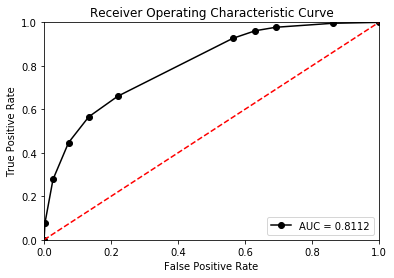

In [43]:
plt.title('Receiver Operating Characteristic Curve')
plt.plot(lst_fpr, lst_tpr, '-ko', label = 'AUC = {}'.format(roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

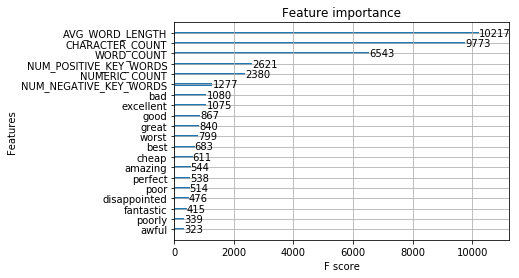

In [44]:
xgboost.plot_importance(xgb, max_num_features = 20)